In [1]:
import os
import sys
import glob
import pickle
import itertools
import random

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

import numpy as np
import pandas as pd


import sys
sys.path.append('../')
from src import *

random.seed(1234)
np.random.seed(1234)
%matplotlib inline

In [2]:
OUTPUT_DIR = "/home/disij/projects/sandbox/fc_mondrian/output/"
PATH_TABLE = '/home/disij/projects/acdc/data/BMMC_benchmark/BMMC_table.csv'
PATH_DATA = "/extra/disij0/data/flow_cytometry/flowMP_output/BMMC_predictions.csv.gz"

In [3]:
# load AML data and table

### LOAD DATA ###
df = pd.read_csv( PATH_DATA, sep=',', header = 0, \
                 compression = 'gzip', engine='python')
table = pd.read_csv(PATH_TABLE, sep=',', header=0, index_col=0)
table = table.fillna(0)

### PROCESS: discard ungated events ###
X = df[df.columns[:-2]].values
table_headers = list(table)

### transform data
data = np.arcsinh((X-1.)/5.)
N, d = data.shape
emp_bounds = np.array([[data[:,d].min(), data[:,d].max()] for d in range(data.shape[1])])
ct2idx = {x:i for i,x in enumerate(table.index)}
idx2ct = {i:x for i,x in enumerate(table.index)}

Y = np.array([ct2idx[_] for _ in df.cell_type])
Y_predict = np.array([ct2idx[_] for _ in df.MP_prediction])

Accuracy on data: 0.923


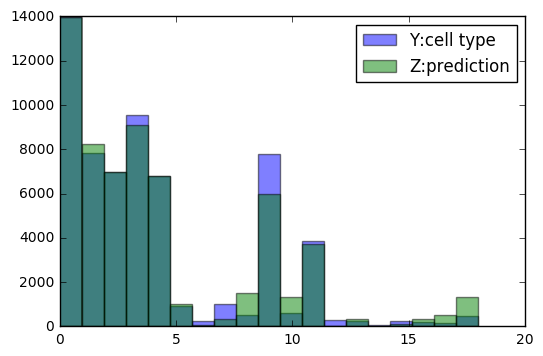

In [4]:
accuracy = sum(Y == Y_predict)*1.0/ data.shape[0]
print "Accuracy on data: %.3f" % accuracy

bins = table.shape[0]
plt.hist(Y, bins, alpha=0.5, label='Y:cell type')
plt.hist(Y_predict, bins, alpha=0.5, label='Z:prediction')
plt.legend(loc='upper right')
plt.show() 

In [5]:
print table.loc[['Pre-B I','Pre-B II','Plasma cell']]
print table.loc[['Immature B','Mature CD38lo B','Mature CD38mid B']]
print table.loc[['Plasmacytoid DC','NK']]
print sum(Y == 6)*1.0/N, sum(Y == 7)*1.0/N, sum(Y == 18)*1.0/N
print sum(Y == 8)*1.0/N, sum(Y == 9)*1.0/N, sum(Y == 10)*1.0/N
print sum(Y == 12)*1.0/N, sum(Y == 11)*1.0/N

             CD45  CD45RA  CD19  CD11b  CD4  CD8  CD34  CD20  CD33  CD123  \
Pre-B I       0.0     0.0     1    0.0   -1   -1   1.0  -1.0    -1    0.0   
Pre-B II      0.0     0.0     1    0.0   -1   -1  -1.0  -1.0    -1    0.0   
Plasma cell   0.0     0.0     1    0.0   -1   -1   0.0  -1.0    -1    0.0   

             CD38  CD90  CD3  
Pre-B I       1.0   0.0   -1  
Pre-B II      1.0   0.0   -1  
Plasma cell   1.0   0.0   -1  
                  CD45  CD45RA  CD19  CD11b  CD4  CD8  CD34  CD20  CD33  \
Immature B         0.0     0.0     1    0.0   -1   -1  -1.0  -1.0    -1   
Mature CD38lo B    0.0     0.0     1    0.0   -1   -1  -1.0   1.0    -1   
Mature CD38mid B   0.0     0.0     1    0.0   -1   -1  -1.0   1.0    -1   

                  CD123  CD38  CD90  CD3  
Immature B          0.0  -1.0   0.0   -1  
Mature CD38lo B     0.0  -1.0   0.0   -1  
Mature CD38mid B    0.0   1.0   0.0   -1  
                 CD45  CD45RA  CD19  CD11b  CD4  CD8  CD34  CD20  CD33  CD123  \
Plasmacytoid 

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    INPUT:
        cm: np.matrix, confusion matrix (can be computed using sklearn)
        classes: a list of strings, each string represents the name of each class
        normalize: normalize cm by row or not
    OUTPUT:
        None
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize ="13")
    plt.yticks(tick_marks, classes,fontsize ="13")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',fontsize ="16")
    plt.xlabel('Predicted label',fontsize ="16")

Normalized confusion matrix


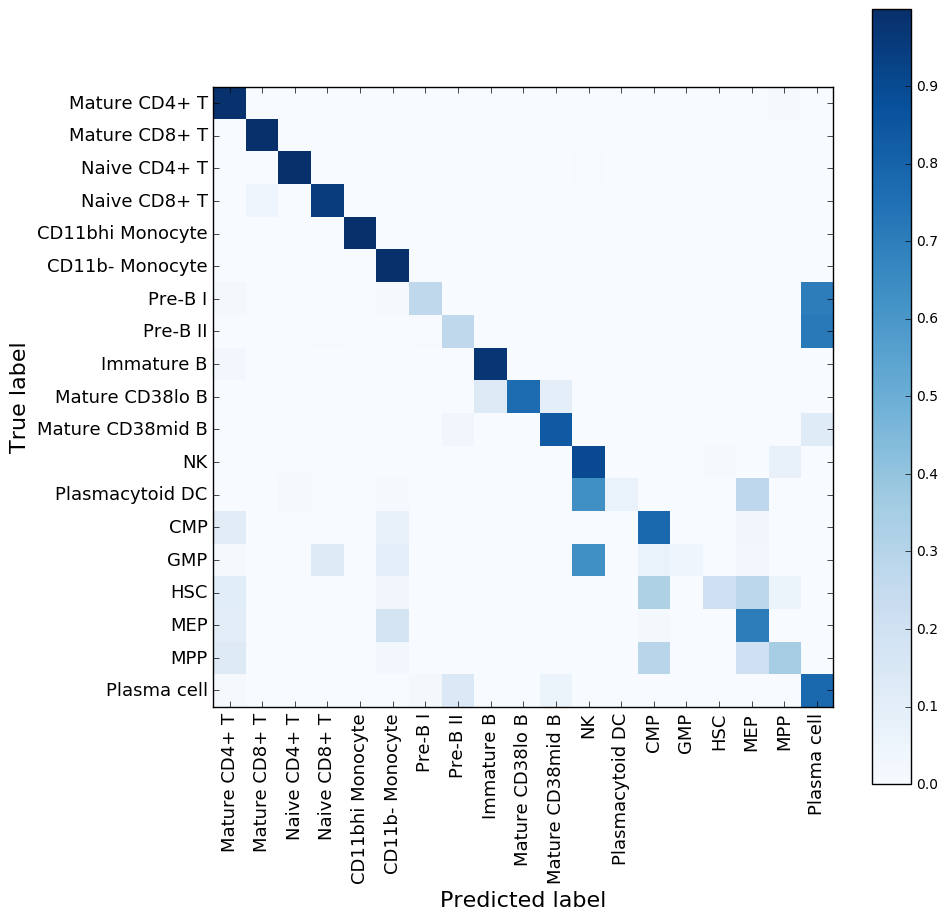

In [14]:
cnf_matrix = confusion_matrix(Y, Y_predict)
class_names = table.index

np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.savefig(OUTPUT_DIR + 'plots/BMMC_confusion_matrix.png', format='png',\
            dpi=2000,bbox_inches = 'tight')
plt.savefig(OUTPUT_DIR + 'plots/BMMC_confusion_matrix.pdf', format='pdf',\
            dpi=2000,bbox_inches = 'tight')
plt.savefig(OUTPUT_DIR + 'plots/BMMC_confusion_matrix.eps', format='eps',\
            dpi=2000,bbox_inches = 'tight')
plt.show()

In [7]:
%%time

idx_plot = np.random.randint(N, size=10000)
data_plot = data[idx_plot]
Y_plot = Y[idx_plot]
Y_predict_plot = Y_predict[idx_plot]

tsne = TSNE(n_components=2, random_state=1234)
Xre = tsne.fit_transform(data_plot)

CPU times: user 2min 47s, sys: 42 s, total: 3min 29s
Wall time: 3min 24s


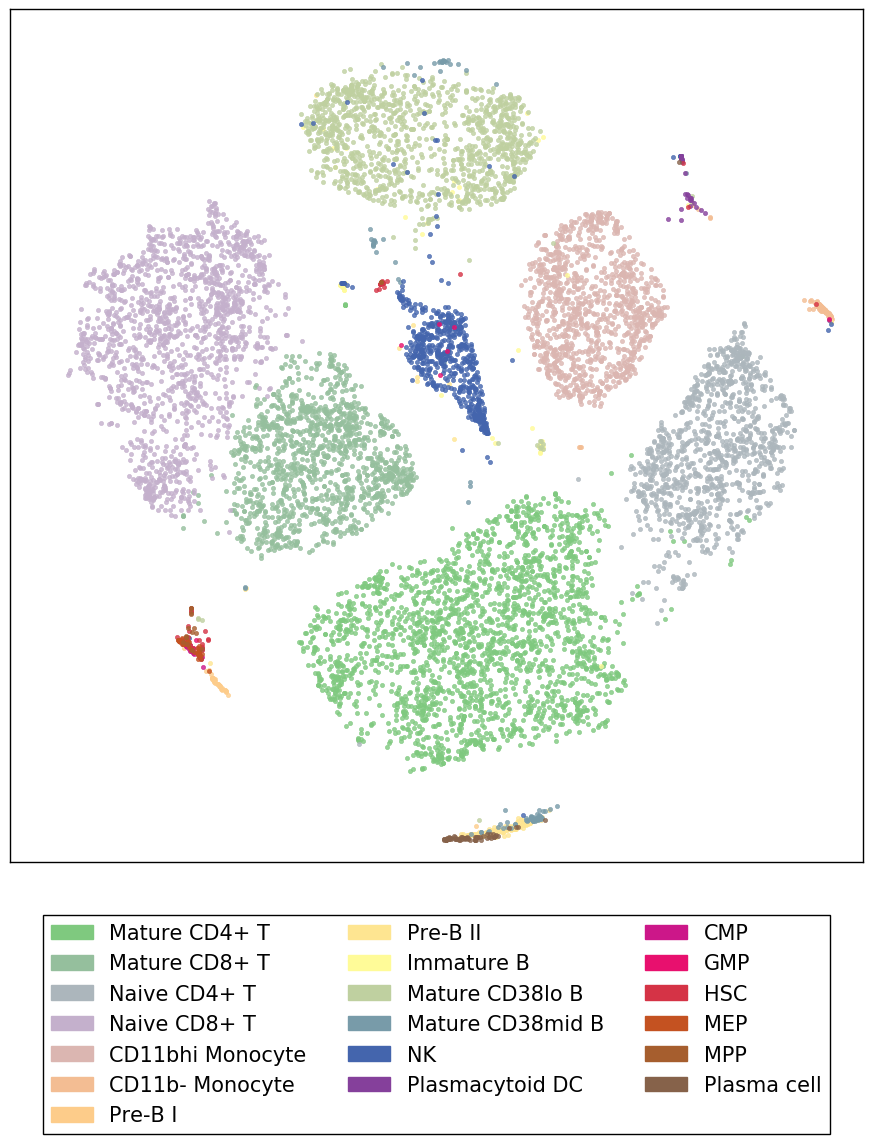

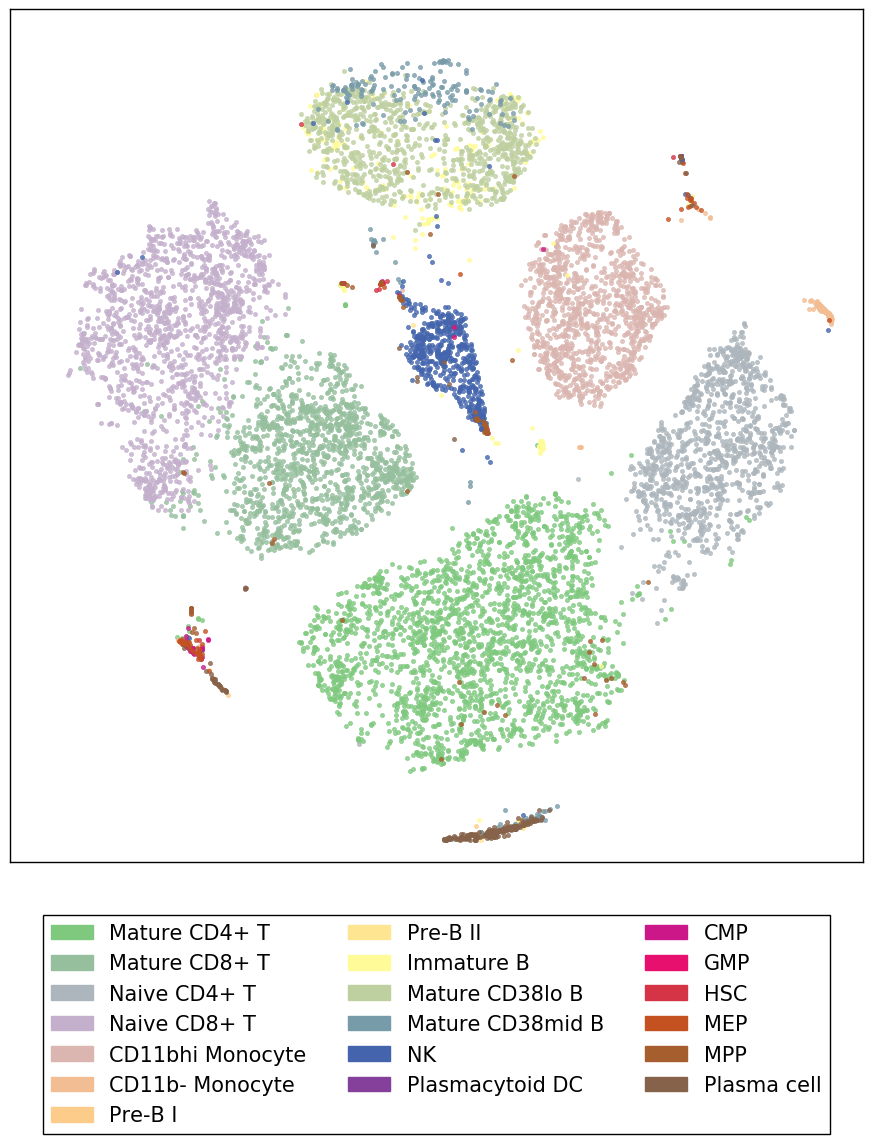

In [12]:
filename = OUTPUT_DIR + 'plots/BMMC_tsne_true.pdf'
plot_tsne(Xre, Y_plot, idx2ct, filename)
filename = OUTPUT_DIR + 'plots/BMMC_tsne_predict.pdf'
plot_tsne(Xre, Y_predict_plot, idx2ct, filename)